# Import library

In [1]:
# 기본 패키지
import pandas as pd
import numpy as np
import os

# 시각화 패키지
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 
plt.style.use(['ggplot'])

# 모델링 패키지
import sklearn
import matplotlib
# import pycaret
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_log_error

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 

# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
# print('pycaret : %s'%(pycaret.__version__))
!python --version

Pandas : 1.2.4
Numpy : 1.20.1
Scikit-Learn : 1.1.2
seaborn : 0.11.1
matplotlib : 3.3.4
Python 3.8.8


# Preprocessing

### Load Data

In [2]:
# Data Load
demo = pd.read_csv('../data/LPOINT_BIG_COMP_01_DEMO.csv', low_memory=False)
pdde = pd.read_csv('../data/LPOINT_BIG_COMP_02_PDDE.csv', low_memory=False)
cop = pd.read_csv('../data/LPOINT_BIG_COMP_03_COP_U.csv', low_memory=False)
clac = pd.read_csv('../data/LPOINT_BIG_COMP_04_PD_CLAC.csv', low_memory=False)
br = pd.read_csv('../data/LPOINT_BIG_COMP_05_BR.csv', low_memory=False)
lpay = pd.read_csv('../data/LPOINT_BIG_COMP_06_LPAY.csv', low_memory=False)

# Column명 변경
demo.columns = ['고객번호', '성별', '연령대', '거주지대분류코드']
pdde.columns = ['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '구매시간', '구매금액', '구매수량']
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '이용일자', '방문일자', '이용시간', '이용금액']
clac.columns = ['상품코드', '소분류명', '대분류명', '중분류명']
br.columns = ['점포코드', '제휴사', '점포대분류코드', '점포중분류코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '이용일자', '이용시간', '이용금액']

### Data Preprocessing

- 가독성을 위하여 불필요한 데이터 확인과정 삭제

####  [2. pdde]: 상품 구매 정보

In [3]:
# 중복되는 행 제거 -> 데이터 추출시 고객, 상품 각각 추출하여 중복이 발생한 것으로 판단함
pdde.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

# 결측치 치환 -> na값을 온라인으로 채워줌
pdde['점포코드'] = pdde['점포코드'].fillna('온라인')

#### [3. cop]: 제휴사 이용 정보

In [4]:
# 결측치 치환
cop['점포코드'] = cop['점포코드'].fillna('온라인')

# Data Merge

In [5]:
# 데이터를 통합하기 위하여 칼럼 통합
pdde['타입'] = 'Product'
cop['타입'] = 'Affiliate'
lpay['타입'] = 'Lpay'
pdde['방문일자'] = 0
lpay['방문일자'] = 0
cop['구매수량'] = 0
cop['상품코드'] = np.nan
lpay['점포코드'] = np.nan
lpay['상품코드'] = np.nan
lpay['구매수량'] = 0

In [6]:
# 칼럼명을 새롭게 동일하게 통일
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '구매일자', '방문일자', '구매시간', '구매금액', '타입', '구매수량', '상품코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '구매일자', '구매시간', '구매금액', '타입', '방문일자', '점포코드', '상품코드', '구매수량']

# 상품구매데이터를 기준으로 하여 열을 통일
cop = cop[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]
lpay = lpay[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]

# 데이터 타입 변경
lpay['영수증번호'] = lpay['영수증번호'].astype('object')
lpay['점포코드'] = lpay['점포코드'].astype('object')
cop['상품코드'] = cop['상품코드'].astype('object')
lpay['상품코드'] = lpay['상품코드'].astype('object')
pdde['구매금액'] = pdde['구매금액'].astype('int')
pdde['방문일자'] = pdde['방문일자'].astype('int64')
lpay['방문일자'] = lpay['방문일자'].astype('int64')

In [7]:
# 데이터 concat
df = pd.concat([pdde,cop,lpay])
# 고객 정보 테이븛 통합
df = pd.merge(df, demo, on = ['고객번호'], how = 'left')
# 상품 분류 테이블 통합
df = pd.merge(df, br, on = ['점포코드','제휴사'], how = 'left')
# 점포 정보 테이블 통합
df = pd.merge(df, clac, on = ['상품코드'], how = 'left')

In [8]:
# 결측치 확인 -> 데이터를 합치면서 생기는 결측치만 존재
df.isnull().sum()

고객번호             0
영수증번호            0
채널구분             0
제휴사              0
점포코드        353184
상품코드        601488
구매일자             0
구매시간             0
구매금액             0
구매수량             0
타입               0
방문일자             0
성별               0
연령대              0
거주지대분류코드         0
점포대분류코드     729023
점포중분류코드     729023
소분류명        601488
대분류명        601488
중분류명        601488
dtype: int64

## Train Test Split

In [9]:
# 날짜로 변경
df['날짜'] = df['구매일자'].astype(str)
df['날짜'] = pd.to_datetime(df['날짜'])
# 각 거래일간의 차이를 구함
df = df.sort_values(by=['날짜'], ascending=[True])
df['diff'] = df.groupby('고객번호')['날짜'].diff().fillna('0').astype(str)
df['diff'] = df['diff'].apply(lambda x: int(x.split()[0]))
# 데이터를 거래횟수별로 나누기 위한 작업
imp = df.groupby('고객번호')['영수증번호'].apply(set).reset_index()
imp['거래횟수'] = imp['영수증번호'].apply(lambda x:len(list(x)))
# 뉴비와 올드비를 구분해줌
oldbie = imp[imp['거래횟수']>3]['고객번호'].tolist()
newbie = imp[imp['거래횟수']<=3]['고객번호'].tolist()

# 데이터 분리
df_old = df[df['고객번호'].isin(oldbie)]
df_new = df[df['고객번호'].isin(newbie)]

# RFM

In [10]:
customer_id = df_old.groupby('고객번호')[['구매일자']].max().index.tolist()
recency = df_old.groupby('고객번호')[['구매일자']].max()['구매일자'].tolist()
freq = df_old.groupby('고객번호')['영수증번호'].apply(set).reset_index()
frequency = freq['영수증번호'].apply(lambda x:len(list(x)))
monetary = df_old.groupby('고객번호')[['구매금액']].sum()['구매금액'].tolist()

df_rfm = pd.DataFrame({'Customer_ID': customer_id, 'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})

In [11]:
df_rfm['Recency'] = df_rfm['Recency'].astype(str)
df_rfm['Recency'] = pd.to_datetime(df_rfm['Recency'])
df_rfm['Recency'] = df_rfm['Recency'] - pd.to_datetime('20210101')
# df_rfm['Recency'] = [x.total_seconds() for x in df_rfm['Recency']]

df_rfm['Recency'] = df_rfm['Recency'].dt.days # days로
df_rfm

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,356,13,616240
1,M000136117,363,89,28697031
2,M000201112,331,5,51420
3,M000225114,364,88,2084270
4,M000261625,337,49,6072050
...,...,...,...,...
26207,M999673157,351,17,2851370
26208,M999770689,364,216,2078770
26209,M999849895,334,35,1095312
26210,M999926092,335,7,129500


# Data Clustering

- k-means를 위한 Scaling

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
import time
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

In [13]:
scaler = StandardScaler()
scaler.fit(df_rfm.iloc[:,1:])

StandardScaler()

In [14]:
rfm_scaled = scaler.transform(df_rfm.iloc[:,1:]) 

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns = df_rfm.iloc[:,1:].columns) 
rfm_scaled_df.insert(0, 'Customer_ID', df_rfm['Customer_ID'])
rfm_scaled_df

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,0.388787,-0.682454,-0.292294
1,M000136117,0.549046,0.211318,1.677066
2,M000201112,-0.183566,-0.776535,-0.331906
3,M000225114,0.571940,0.199558,-0.189339
4,M000261625,-0.046201,-0.259088,0.090332
...,...,...,...,...
26207,M999673157,0.274316,-0.635413,-0.135540
26208,M999770689,0.571940,1.704857,-0.189724
26209,M999849895,-0.114884,-0.423730,-0.258696
26210,M999926092,-0.091990,-0.753015,-0.326430


- Clustering

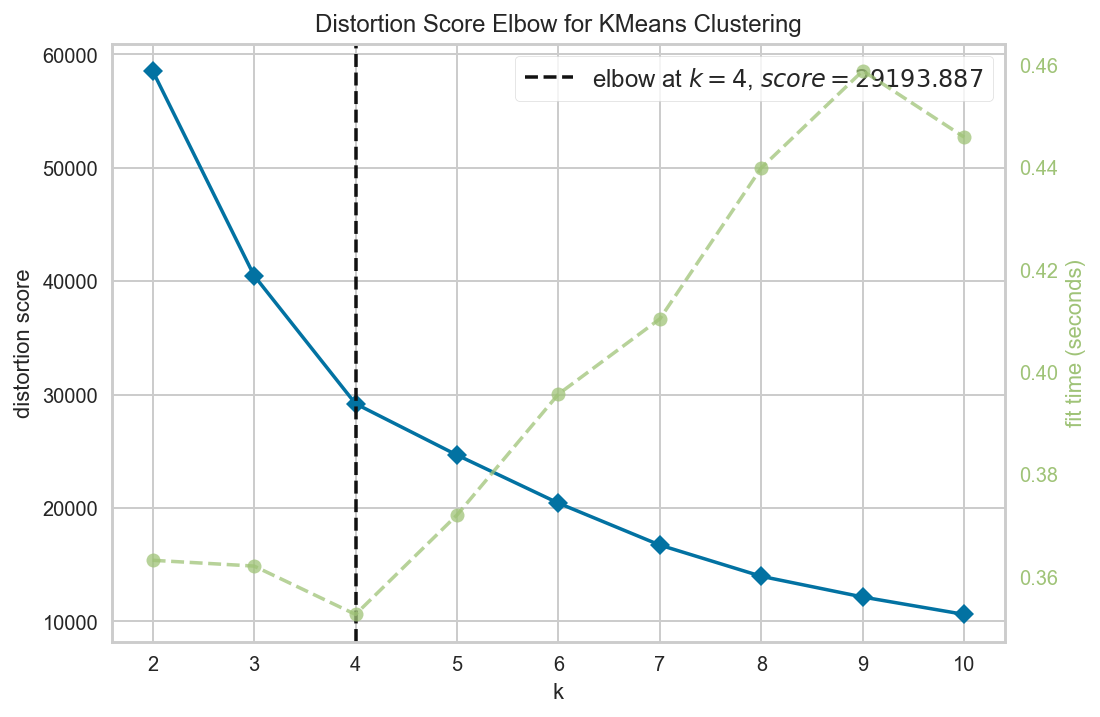

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
kmeans = KMeans(random_state=np.random.RandomState(seed=42))

elb_visualizer = KElbowVisualizer(kmeans, k=(2,11))
elb_visualizer.fit(rfm_scaled_df.iloc[:,1:])
elb_visualizer.show()

- 실루엣 계수 확인

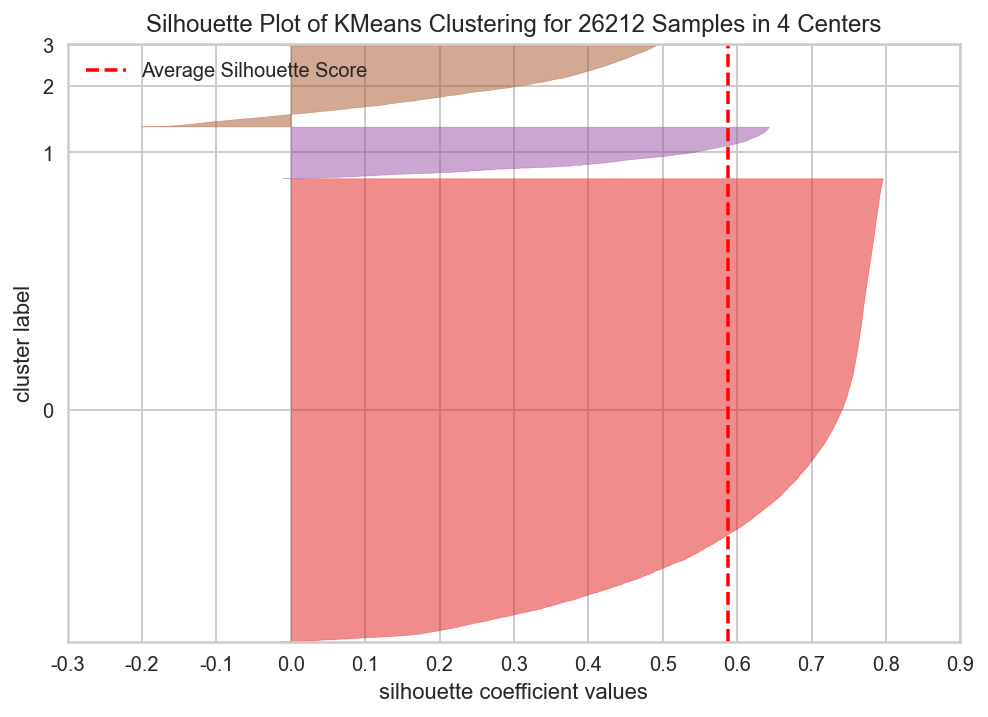

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 26212 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:
model_4clust = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))

sil_visualizer = SilhouetteVisualizer(model_4clust)
sil_visualizer.fit(rfm_scaled_df.iloc[:,1:])
sil_visualizer.show()

- 군집 라벨링

In [17]:
kmeans = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))
labels = kmeans.fit_predict(rfm_scaled_df.iloc[:,1:])

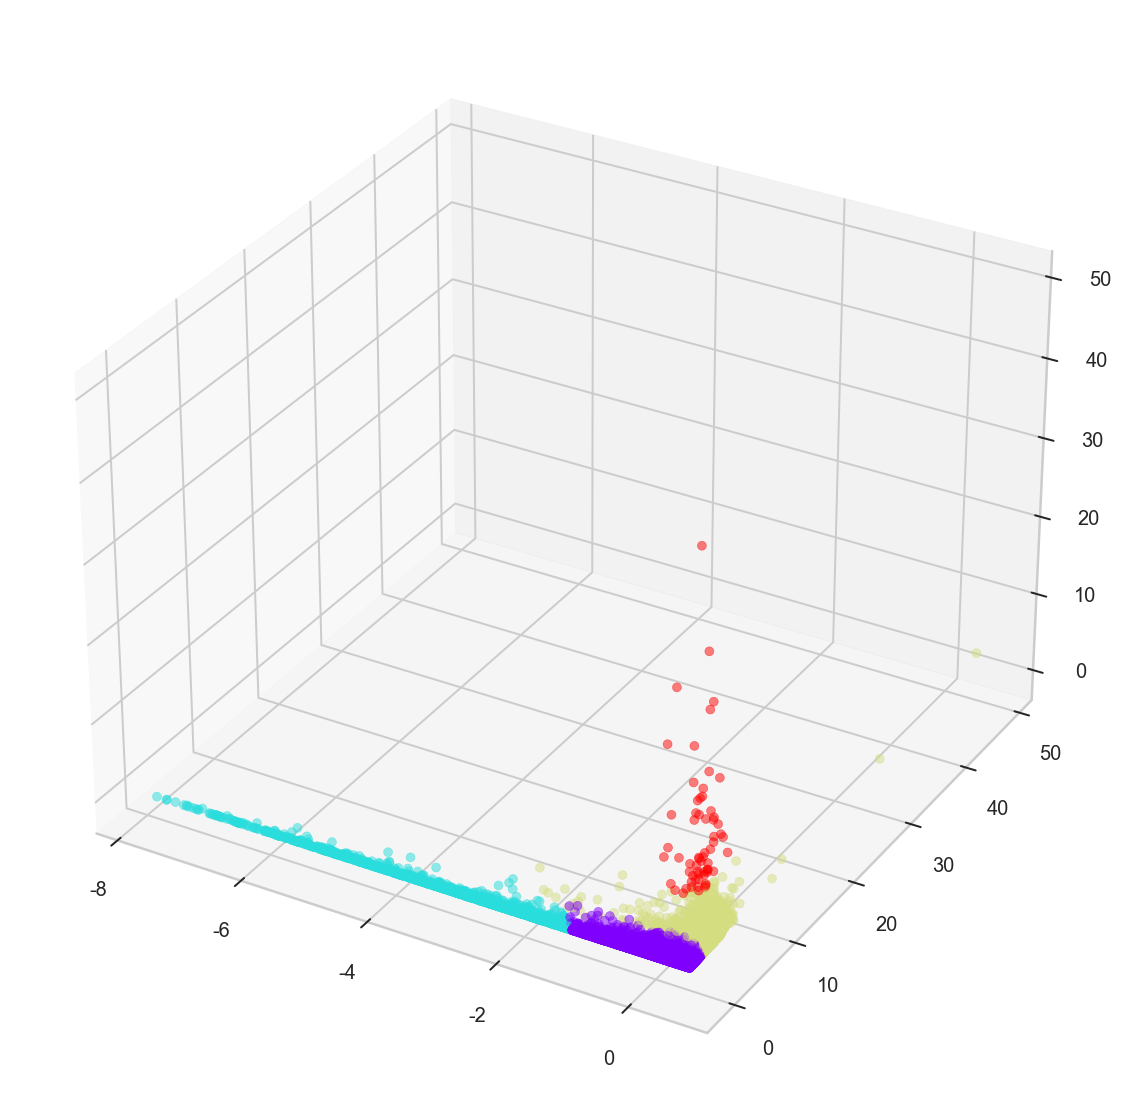

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = rfm_scaled_df['Recency']
y = rfm_scaled_df['Frequency']
z = rfm_scaled_df['Monetary']
ax.scatter(x, y, z, c = labels, s= 20, alpha=0.5, cmap='rainbow')

In [19]:
rfm_scaled_df['labels'] = labels
rfm_df = rfm_scaled_df[['Customer_ID', 'labels']]
rfm_df.columns = ['고객번호', 'labels']
rfm_df.head(3)

,고객번호,labels
0,M000034966,0
1,M000136117,2
2,M000201112,0


- data merge

In [20]:
df_old = pd.merge(df_old, rfm_df, on = ['고객번호'], how = 'left')
df_old.head(3)

,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,연령대,거주지대분류코드,점포대분류코드,점포중분류코드,소분류명,대분류명,중분류명,날짜,diff,labels
0,M495972460,20122713C012328716,2,C01,C010004,NaN,20201227,13,26000,0,...,40대,Z10,Z17,Z17011,NaN,NaN,NaN,2020-12-27,0,0
1,M039320884,20122911C011862577,2,C01,C010117,NaN,20201229,11,6500,0,...,40대,Z06,Z06,Z06013,NaN,NaN,NaN,2020-12-29,0,2
2,M192531170,20122900C013317930,2,C01,C010026,NaN,20201229,0,10000,0,...,40대,Z10,Z10,Z10011,NaN,NaN,NaN,2020-12-29,0,0


In [21]:
rfm_df = pd.merge(rfm_df, demo[demo['고객번호'].isin(oldbie)].reset_index(drop=True), how='inner',on='고객번호')

In [22]:
# 열 순서 변경
rfm_df = rfm_df[['고객번호', '성별', '연령대', '거주지대분류코드', 'labels']]

## 파생변수 생성

- 영수증 번호의 길이

In [23]:
# 영수증 번호의 길이가 12, 15, 18 3가지로 나누어지는데 이는 각 다른 점포에서 결제한 것을 의미할 것이라고 판단하여 새로운 파생변수로 생성
df_old['영수증번호길이'] = df_old['영수증번호'].apply(lambda x: len(str(x)))
df_old['영수증번호길이'].value_counts()

12    4134942
15     353002
18     245778
Name: 영수증번호길이, dtype: int64

In [24]:
rfm_df['영수증번호길이평균'] = df_old.groupby('고객번호')[['영수증번호길이']].mean()['영수증번호길이'].tolist()
rfm_df['영수증번호길이최대'] = df_old.groupby('고객번호')['영수증번호길이'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대
0,M000034966,여성,40대,Z07,0,12.122449,12
1,M000136117,여성,30대,Z11,2,12.842975,12
2,M000201112,여성,50대,Z17,0,12.000000,12
3,M000225114,여성,40대,Z17,0,12.368098,12
4,M000261625,여성,40대,Z17,0,12.089552,12
...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12
26208,M999770689,여성,30대,Z16,2,12.813433,12
26209,M999849895,여성,20대,Z04,0,12.085714,12
26210,M999926092,남성,30대,Z08,0,18.000000,18


- 영수증의 타입

In [25]:
# 영수증 번호의 타입을 생성하는 함수
def receipt_type(x):
    if len(str(x)) == 18:
        return str(x)[8]
    elif len(str(x)) == 15:
        return 'number'
    elif len(str(x)) == 12:
        return str(x)[0]

In [26]:
# 영수증마다 하나의 영어를 포함하거나, 모두 숫자로 이루어져있기 때문에 이러한 타입을 나타내는 파생변수를 생성
df_old['영수증타입'] = df_old['영수증번호'].apply(receipt_type)
df_old['영수증타입'].value_counts()

A         3760036
E          381115
number     353002
D          154419
C           77108
B            8042
Name: 영수증타입, dtype: int64

In [27]:
rfm_df['영수증타입최대값'] = df_old.groupby('고객번호')['영수증타입'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값
0,M000034966,여성,40대,Z07,0,12.122449,12,A
1,M000136117,여성,30대,Z11,2,12.842975,12,A
2,M000201112,여성,50대,Z17,0,12.000000,12,A
3,M000225114,여성,40대,Z17,0,12.368098,12,A
4,M000261625,여성,40대,Z17,0,12.089552,12,A
...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A
26208,M999770689,여성,30대,Z16,2,12.813433,12,A
26209,M999849895,여성,20대,Z04,0,12.085714,12,A
26210,M999926092,남성,30대,Z08,0,18.000000,18,D


- 최대 구매 경로

In [28]:
df_old['채널구분'].value_counts()

1    4122105
2     611617
Name: 채널구분, dtype: int64

In [29]:
def buy_root(x):
    if x == 1:
        return '오프라인'
    elif x == 2:
        return '온라인'

In [30]:
rfm_df['최다구매경로'] = df_old.groupby('고객번호')['채널구분'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df['최다구매경로'] = rfm_df['최다구매경로'].apply(buy_root)
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인
...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인


- 제휴사의 타입

In [31]:
# 제휴사의 제일 앞에 알파벳의 경우에는 제휴사의 타입을 나타낼 수 있기 때문에 파생변수로 생성
df_old['제휴사타입'] = df_old['제휴사'].apply(lambda x: str(x)[0])
df_old['제휴사타입'].value_counts()

A    4362804
D     171769
L      93429
C      90236
B       8811
E       6673
Name: 제휴사타입, dtype: int64

In [32]:
rfm_df['최다제휴사타입'] = df_old.groupby('고객번호')['제휴사타입'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df['최다제휴사'] = df_old.groupby('고객번호')['제휴사'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,A02
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,A01
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,A04
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,A01
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,A01
...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,A04
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,A04
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,A02
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,D02


- 상품코드와 점포코드의 경우는 파생변수 생성 보류

- 구매일자관련 파생변수

In [33]:
df_old['구매일자'] = pd.to_datetime(df_old['구매일자'].astype(str))
df_old['구매년도'] = df_old['구매일자'].dt.year
df_old['구매월'] = df_old['구매일자'].dt.month
df_old['구매일'] = df_old['구매일자'].dt.day
df_old['구매요일'] = df_old['구매일자'].dt.weekday
df_old

,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,날짜,diff,labels,영수증번호길이,영수증타입,제휴사타입,구매년도,구매월,구매일,구매요일
0,M495972460,20122713C012328716,2,C01,C010004,NaN,2020-12-27,13,26000,0,...,2020-12-27,0,0,18,C,C,2020,12,27,6
1,M039320884,20122911C011862577,2,C01,C010117,NaN,2020-12-29,11,6500,0,...,2020-12-29,0,2,18,C,C,2020,12,29,1
2,M192531170,20122900C013317930,2,C01,C010026,NaN,2020-12-29,0,10000,0,...,2020-12-29,0,0,18,C,C,2020,12,29,1
3,M864132607,20123021C013512700,2,C01,C010086,NaN,2020-12-30,21,15000,0,...,2020-12-30,0,0,18,C,C,2020,12,30,2
4,M577916024,20123012C012610437,2,C01,C010102,NaN,2020-12-30,12,16000,0,...,2020-12-30,0,0,18,C,C,2020,12,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4733717,M593010408,A03159704778,1,A03,A030337,PD0232,2021-12-31,15,3990,1,...,2021-12-31,0,0,12,A,A,2021,12,31,4
4733718,M593010408,A03159704778,1,A03,A030337,PD1333,2021-12-31,15,2550,2,...,2021-12-31,0,0,12,A,A,2021,12,31,4
4733719,M593010408,A03159704778,1,A03,A030337,PD1343,2021-12-31,15,1390,2,...,2021-12-31,0,0,12,A,A,2021,12,31,4
4733720,M714979893,A03158123233,1,A03,A030331,PD1249,2021-12-31,12,3600,1,...,2021-12-31,0,2,12,A,A,2021,12,31,4


- 구매년도

In [34]:
rfm_df['최다구매년도'] = df_old.groupby('고객번호')['구매년도'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,A02,2021
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,A01,2021
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,A04,2021
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,A01,2021
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,A01,2021
...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,A04,2021
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,A04,2021
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,A02,2021
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,D02,2021


- 구매월

In [35]:
rfm_df['구매월평균'] = df_old.groupby('고객번호')[['구매월']].mean()['구매월'].tolist()
rfm_df['최다구매월'] = df_old.groupby('고객번호')['구매월'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,A02,2021,7.591837,9
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,A01,2021,5.553719,1
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,A04,2021,7.850000,7
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,A01,2021,6.975460,4
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,A01,2021,6.701493,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,A04,2021,7.291667,12
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,A04,2021,6.465174,2
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,A02,2021,7.185714,8
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,D02,2021,6.000000,1


In [36]:
# 최다 구매 계절의 파생변수를 만들기 위해 계절을 나누는 파생변수 생성
def season(x):
    if x >= 3 and x <= 5:
        return '봄'
    elif x >= 6 and x <= 7:
        return '여름'
    elif x >= 8 and x <= 11:
        return '가을'
    else:
        return '겨울'

In [37]:
df_old['구매계절'] = df_old['구매월'].apply(season)
rfm_df['최다구매계절'] = df_old.groupby('고객번호')['구매계절'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월,최다구매계절
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,A02,2021,7.591837,9,가을
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,A01,2021,5.553719,1,겨울
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,A04,2021,7.850000,7,가을
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,A01,2021,6.975460,4,봄
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,A01,2021,6.701493,7,가을
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,A04,2021,7.291667,12,겨울
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,A04,2021,6.465174,2,가을
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,A02,2021,7.185714,8,가을
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,D02,2021,6.000000,1,겨울


In [38]:
rfm_df['평균구매일'] = df_old.groupby('고객번호')[['구매일']].mean()['구매일'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월,최다구매계절,평균구매일
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,A02,2021,7.591837,9,가을,20.959184
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,A01,2021,5.553719,1,겨울,13.958678
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,A04,2021,7.850000,7,가을,18.850000
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,A01,2021,6.975460,4,봄,13.981595
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,A01,2021,6.701493,7,가을,9.611940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,A04,2021,7.291667,12,겨울,16.625000
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,A04,2021,6.465174,2,가을,15.223881
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,A02,2021,7.185714,8,가을,10.728571
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,D02,2021,6.000000,1,겨울,17.857143


In [39]:
# 요일을 만드는 파생변수 생성
def dayofweek(x):
    if x == 0:
        return '월요일'
    elif x == 1:
        return '화요일'
    elif x == 2:
        return '수요일'
    elif x == 3:
        return '목요일'
    elif x == 4:
        return '금요일'
    elif x == 5:
        return '토요일'
    elif x == 6:
        return '일요일'

In [40]:
df_old['구매요일'] = df_old['구매요일'].apply(dayofweek)
rfm_df['구매요일최대값'] = df_old.groupby('고객번호')[['구매요일']].max()['구매요일'].tolist()
rfm_df['최다구매요일'] = df_old.groupby('고객번호')['구매요일'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월,최다구매계절,평균구매일,구매요일최대값,최다구매요일
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,A02,2021,7.591837,9,가을,20.959184,화요일,일요일
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,A01,2021,5.553719,1,겨울,13.958678,화요일,목요일
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,A04,2021,7.850000,7,가을,18.850000,일요일,일요일
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,A01,2021,6.975460,4,봄,13.981595,화요일,화요일
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,A01,2021,6.701493,7,가을,9.611940,화요일,토요일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,A04,2021,7.291667,12,겨울,16.625000,화요일,목요일
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,A04,2021,6.465174,2,가을,15.223881,화요일,목요일
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,A02,2021,7.185714,8,가을,10.728571,화요일,수요일
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,D02,2021,6.000000,1,겨울,17.857143,화요일,목요일


In [41]:
def weekday(x):
    if x == '토요일' or x == '일요일':
        return '주말'
    else:
        return '주중'

In [42]:
df_old['주중주말여부'] = df_old['구매요일'].apply(weekday)
rfm_df['주중주말선호도'] = df_old.groupby('고객번호')['주중주말여부'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월,최다구매계절,평균구매일,구매요일최대값,최다구매요일,주중주말선호도
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,A02,2021,7.591837,9,가을,20.959184,화요일,일요일,주말
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,A01,2021,5.553719,1,겨울,13.958678,화요일,목요일,주중
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,A04,2021,7.850000,7,가을,18.850000,일요일,일요일,주말
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,A01,2021,6.975460,4,봄,13.981595,화요일,화요일,주중
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,A01,2021,6.701493,7,가을,9.611940,화요일,토요일,주중
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,A04,2021,7.291667,12,겨울,16.625000,화요일,목요일,주중
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,A04,2021,6.465174,2,가을,15.223881,화요일,목요일,주중
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,A02,2021,7.185714,8,가을,10.728571,화요일,수요일,주중
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,D02,2021,6.000000,1,겨울,17.857143,화요일,목요일,주중


- 구매시간 관련 파생변수

In [43]:
rfm_df['평균구매시간'] = df_old.groupby('고객번호')[['구매시간']].mean()['구매시간'].tolist()
rfm_df['최다구매시간'] = df_old.groupby('고객번호')['구매시간'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,...,최다구매년도,구매월평균,최다구매월,최다구매계절,평균구매일,구매요일최대값,최다구매요일,주중주말선호도,평균구매시간,최다구매시간
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,...,2021,7.591837,9,가을,20.959184,화요일,일요일,주말,16.693878,16
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,...,2021,5.553719,1,겨울,13.958678,화요일,목요일,주중,15.413223,15
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,...,2021,7.850000,7,가을,18.850000,일요일,일요일,주말,11.800000,15
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,...,2021,6.975460,4,봄,13.981595,화요일,화요일,주중,17.331288,18
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,...,2021,6.701493,7,가을,9.611940,화요일,토요일,주중,15.462687,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,...,2021,7.291667,12,겨울,16.625000,화요일,목요일,주중,13.833333,1
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,...,2021,6.465174,2,가을,15.223881,화요일,목요일,주중,12.950249,21
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,...,2021,7.185714,8,가을,10.728571,화요일,수요일,주중,15.800000,19
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,...,2021,6.000000,1,겨울,17.857143,화요일,목요일,주중,16.857143,16


In [44]:
def hour_type(x):
    if x < 6:
        return '새벽'
    elif x >= 6 and x < 12:
        return '오전'
    elif x < 18 and x >= 12:
        return '오후'
    else:
        return '저녁'

In [45]:
df_old['구매시간분류'] = df_old['구매시간'].apply(hour_type)
rfm_df['주구매시간분류'] = df_old.groupby('고객번호')['구매시간분류'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,...,구매월평균,최다구매월,최다구매계절,평균구매일,구매요일최대값,최다구매요일,주중주말선호도,평균구매시간,최다구매시간,주구매시간분류
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,...,7.591837,9,가을,20.959184,화요일,일요일,주말,16.693878,16,오후
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,...,5.553719,1,겨울,13.958678,화요일,목요일,주중,15.413223,15,오후
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,...,7.850000,7,가을,18.850000,일요일,일요일,주말,11.800000,15,오후
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,...,6.975460,4,봄,13.981595,화요일,화요일,주중,17.331288,18,저녁
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,...,6.701493,7,가을,9.611940,화요일,토요일,주중,15.462687,18,오후
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,...,7.291667,12,겨울,16.625000,화요일,목요일,주중,13.833333,1,오후
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,...,6.465174,2,가을,15.223881,화요일,목요일,주중,12.950249,21,오전
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,...,7.185714,8,가을,10.728571,화요일,수요일,주중,15.800000,19,오후
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,...,6.000000,1,겨울,17.857143,화요일,목요일,주중,16.857143,16,오후


- 구매금액 관련 파생변수

In [46]:
rfm_df['평균구매금액'] = df_old.groupby('고객번호')[['구매금액']].mean()['구매금액'].tolist()
rfm_df['최대구매금액'] = df_old.groupby('고객번호')['구매금액'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df['최소구매금액'] = df_old.groupby('고객번호')[['구매금액']].min()['구매금액'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,...,평균구매일,구매요일최대값,최다구매요일,주중주말선호도,평균구매시간,최다구매시간,주구매시간분류,평균구매금액,최대구매금액,최소구매금액
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,...,20.959184,화요일,일요일,주말,16.693878,16,오후,12576.326531,1980,100
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,...,13.958678,화요일,목요일,주중,15.413223,15,오후,237165.545455,14300,100
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,...,18.850000,일요일,일요일,주말,11.800000,15,오후,2571.000000,1700,20
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,...,13.981595,화요일,화요일,주중,17.331288,18,저녁,12786.932515,3000,300
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,...,9.611940,화요일,토요일,주중,15.462687,18,오후,90627.611940,20000,2600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,...,16.625000,화요일,목요일,주중,13.833333,1,오후,118807.083333,4500,50
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,...,15.223881,화요일,목요일,주중,12.950249,21,오전,5171.069652,1000,50
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,...,10.728571,화요일,수요일,주중,15.800000,19,오후,15647.314286,9900,840
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,...,17.857143,화요일,목요일,주중,16.857143,16,오후,18500.000000,25200,10000


- 구매수량 관련 파생변수

In [47]:
rfm_df['평균구매수량'] = df_old.groupby('고객번호')[['구매수량']].mean()['구매수량'].tolist()
rfm_df['최대구매수량'] = df_old.groupby('고객번호')['구매수량'].agg(lambda x:x.value_counts().index[0]).tolist()
rfm_df['최소구매수량'] = df_old.groupby('고객번호')[['구매수량']].min()['구매수량'].tolist()
rfm_df['평균낱개구매금액'] = [(x/y) if y != 0 else 0 for x,y in zip(rfm_df['평균구매금액'], rfm_df['평균구매수량'])]
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,...,평균구매시간,최다구매시간,주구매시간분류,평균구매금액,최대구매금액,최소구매금액,평균구매수량,최대구매수량,최소구매수량,평균낱개구매금액
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,...,16.693878,16,오후,12576.326531,1980,100,1.224490,1,0,10270.666667
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,...,15.413223,15,오후,237165.545455,14300,100,0.884298,1,0,268196.551402
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,...,11.800000,15,오후,2571.000000,1700,20,1.450000,1,1,1773.103448
3,M000225114,여성,40대,Z17,0,12.368098,12,A,오프라인,A,...,17.331288,18,저녁,12786.932515,3000,300,1.073620,1,0,11910.114286
4,M000261625,여성,40대,Z17,0,12.089552,12,A,오프라인,A,...,15.462687,18,오후,90627.611940,20000,2600,1.044776,1,0,86743.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,12,A,오프라인,A,...,13.833333,1,오후,118807.083333,4500,50,1.166667,1,1,101834.642857
26208,M999770689,여성,30대,Z16,2,12.813433,12,A,오프라인,A,...,12.950249,21,오전,5171.069652,1000,50,0.940299,1,0,5499.391534
26209,M999849895,여성,20대,Z04,0,12.085714,12,A,오프라인,A,...,15.800000,19,오후,15647.314286,9900,840,1.657143,1,0,9442.344828
26210,M999926092,남성,30대,Z08,0,18.000000,18,D,오프라인,D,...,16.857143,16,오후,18500.000000,25200,10000,0.000000,0,0,0.000000


- 구매품목수의 경우 신규 고객은 모두 적은 수가 되기 때문에 모델을 사용하지 못하는 문제가 생길 수 있으므로 제거하는 것이 좋다고 판단됨

In [48]:
# rfm_df['구매품목수'] = df_old.groupby('고객번호')[['영수증번호']].count()['영수증번호'].tolist()

## 피처 추가_찬진
    - EDA 결과 나타난 유형별 특징을 바탕으로 특징을 잘 잡을 수 있는 파생변수 생성

In [49]:
# 온라인, 오프라인, 둘다
def div_ch(x):
    if set(x) == {1}: # 오프라인만 이용하는 경우
        return '오프라인'
    elif set(x) == {2}: # 온라인만 이용
        return '온라인'
    else: # 둘다이용
        return '둘다이용'

# 이용채널과 이용 횟수를 구해줌
rfm_df['이용채널'] = df_old.groupby('고객번호')['채널구분'].apply(list).reset_index()['채널구분'].apply(div_ch)

In [50]:
# 엘페이 이용 여부
lpay_user = df_old[df_old['타입'] == 'Lpay']['고객번호'].unique()
rfm_df['Lpay이용여부'] = rfm_df['고객번호'].apply(lambda x:'Lpay사용' if x in lpay_user else 'Lpay미사용')

In [51]:
# 최다구매 중분류명, 대분류명
rfm_df['최다구매중분류명'] = df_old.groupby('고객번호')['중분류명'].apply(list).apply(lambda x:max(x, key = x.count)).reset_index()['중분류명']
rfm_df['최다구매대분류명'] = df_old.groupby('고객번호')['대분류명'].apply(list).apply(lambda x:max(x, key = x.count)).reset_index()['대분류명']

In [52]:
rfm_df.head(3)

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증번호길이최대,영수증타입최대값,최다구매경로,최다제휴사타입,...,최대구매금액,최소구매금액,평균구매수량,최대구매수량,최소구매수량,평균낱개구매금액,이용채널,Lpay이용여부,최다구매중분류명,최다구매대분류명
0,M000034966,여성,40대,Z07,0,12.122449,12,A,오프라인,A,...,1980,100,1.224490,1,0,10270.666667,오프라인,Lpay미사용,스낵류,과자
1,M000136117,여성,30대,Z11,2,12.842975,12,A,오프라인,A,...,14300,100,0.884298,1,0,268196.551402,둘다이용,Lpay사용,NaN,NaN
2,M000201112,여성,50대,Z17,0,12.000000,12,A,오프라인,A,...,1700,20,1.450000,1,1,1773.103448,오프라인,Lpay미사용,냉장조리,대용식


- 주구매 대분류, 중분류, 소분류

In [53]:
df_old['대분류명'].fillna('없음', inplace = True)
df_old['중분류명'].fillna('없음', inplace = True)
df_old['소분류명'].fillna('없음', inplace = True)

In [54]:
# # Data Leakage로 인하여 임시적으로 제거
# rfm_df['주구매대분류'] = df_old.groupby('고객번호')['대분류명'].agg(lambda x:x.value_counts().index[0]).tolist()
# rfm_df['주구매중분류'] = df_old.groupby('고객번호')['중분류명'].agg(lambda x:x.value_counts().index[0]).tolist()
# rfm_df['주구매소분류'] = df_old.groupby('고객번호')['소분류명'].agg(lambda x:x.value_counts().index[0]).tolist()
# rfm_df

## Modeling

In [55]:
target = rfm_df['labels']
data = rfm_df.drop(columns='labels')

# train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=42)
# 인덱스를 지워줌
x_train, x_test, y_train, y_test = x_train.reset_index(drop=True), x_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

- Preprocessing

In [56]:
# encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# eval
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
# model
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [57]:
# 범주형 변수와 수치형 변수를 분리
## train
cat_feature_tr = x_train.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_tr = x_train.iloc[:,1:].select_dtypes(exclude='object').columns.to_list() 
## test
cat_feature_te = x_test.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_te = x_test.iloc[:,1:].select_dtypes(exclude='object').columns.to_list() 

    -  인코딩 시 test에만 있고 train에는 없는 컬럼 처리가 힘든 문제가 생김
    -> 임시로 해결을 위해 train과 test를 합쳐서 인코딩해줌

In [58]:
# #onehotencoder
# ohe = OneHotEncoder(sparse=False)

# # fit_transform은 train에만 사용하고 test에는 학습된 인코더에 fit만 해야한다
# ohe_ = ohe.fit(pd.concat([x_train, x_test]).reset_index(drop=True)[cat_feature_tr])
# one_cat_tr = ohe_.transform(x_train[cat_feature_tr])
# one_cat_te = ohe_.transform(x_test[cat_feature_te])

# cat_tr = pd.DataFrame(one_cat_tr, columns = ohe.get_feature_names(cat_feature_tr)) # train
# cat_te = pd.DataFrame(one_cat_te, columns = ohe.get_feature_names(cat_feature_te)) # test

In [59]:
# Labelencoder
encoder = LabelEncoder()
encoded_cat_tr = []
encoded_cat_te = []
for f in cat_feature_tr:
    encoder = encoder.fit(pd.concat([x_train, x_test]).reset_index(drop=True)[f])
    encoded_cat_tr.append(pd.DataFrame(encoder.transform(x_train[f]),columns = [f])) # train
    encoded_cat_te.append(pd.DataFrame(encoder.transform(x_test[f]),columns = [f]))	# test

# 합쳐줌
cat_tr = pd.concat(encoded_cat_tr, axis = 1) # train
cat_te = pd.concat(encoded_cat_te, axis = 1) # test

In [60]:
x_train_imp = pd.concat([x_train['고객번호'], cat_tr], axis=1)
x_test_imp = pd.concat([x_test['고객번호'], cat_te], axis=1)

x_train = pd.concat([x_train_imp, x_train[num_feature_tr]], axis=1)
x_test = pd.concat([x_test_imp, x_test[num_feature_te]], axis=1)

- catboost modeling

In [61]:
# model = RandomForestClassifier(random_state=42)
cat = CatBoostClassifier(random_state=42, verbose=0)

score = np.mean(cross_val_score(cat, x_train.iloc[:,1:], y_train, cv=5, scoring = 'f1_macro')) # 모델의 성능 확인 -> cv
score

0.5584438811737761

- catboost inference

In [62]:
cat.fit(x_train.iloc[:,1:], y_train)
pred = cat.predict(x_test.iloc[:,1:])

f1_score(y_test, pred, average='macro')

0.5993725238778576

- randomforest modeling

In [63]:
rf = RandomForestClassifier(random_state=42)
score = np.mean(cross_val_score(rf, x_train.iloc[:,1:], y_train, cv=5, scoring = 'f1_macro')) # 모델의 성능 확인 -> cv
score

0.5027471119750918

- randomforest inference

In [64]:
rf.fit(x_train.iloc[:,1:], y_train)
pred = rf.predict(x_test.iloc[:,1:])

f1_score(y_test, pred, average='macro')

0.5658141165441248

In [65]:
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

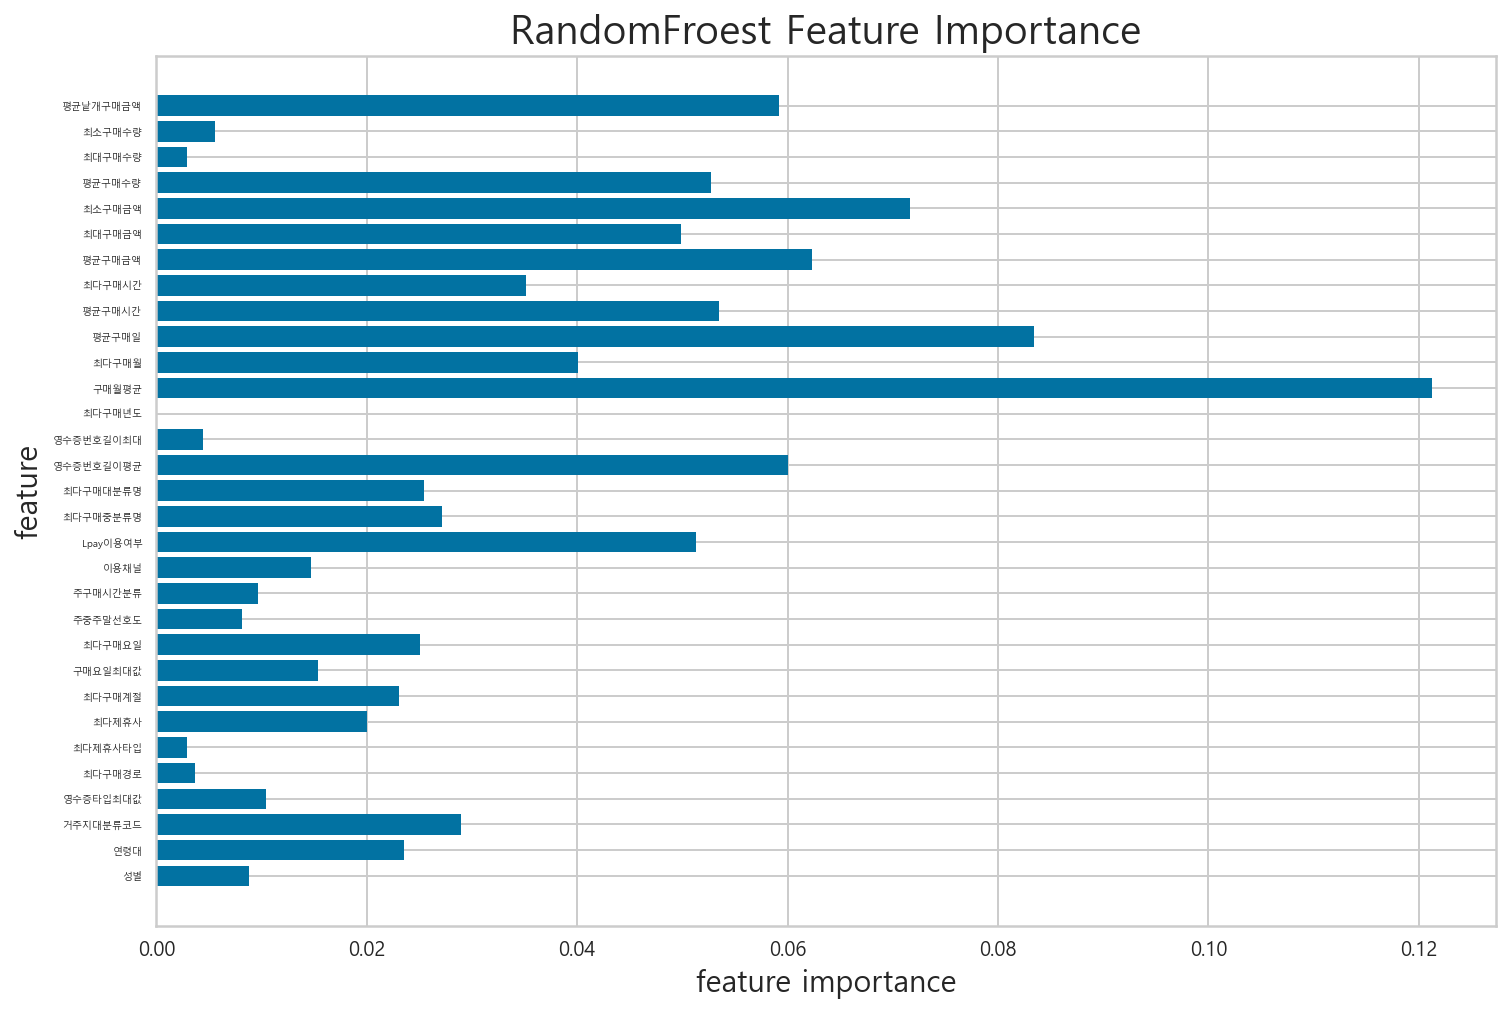

In [66]:
feature_name = list(x_train.columns)[1:]
n_feature = x_train.shape[1]-1
idx = np.arange(n_feature)

plt.figure(figsize=(12, 8))
plt.barh(idx, rf.feature_importances_, align='center')
plt.title('RandomFroest Feature Importance', fontsize=20)

plt.yticks(idx, feature_name, fontsize = 5)
plt.xlabel('feature importance', size = 15)
plt.ylabel('feature', size = 15)
plt.show()

In [67]:
sorted({x:y for x,y in zip(feature_name, rf.feature_importances_)}.items(),key=lambda x: x[1], reverse=True)

[('구매월평균', 0.12124131808667082),
 ('평균구매일', 0.08342485952771303),
 ('최소구매금액', 0.07168049816320117),
 ('평균구매금액', 0.062280807079291345),
 ('영수증번호길이평균', 0.060036526470657554),
 ('평균낱개구매금액', 0.05917050544885153),
 ('평균구매시간', 0.05348648595079697),
 ('평균구매수량', 0.05269854144327017),
 ('Lpay이용여부', 0.05132637287114157),
 ('최대구매금액', 0.049864395404329326),
 ('최다구매월', 0.04003742067196582),
 ('최다구매시간', 0.03510391091464956),
 ('거주지대분류코드', 0.02897425903560668),
 ('최다구매중분류명', 0.027114738297239815),
 ('최다구매대분류명', 0.025438614947303713),
 ('최다구매요일', 0.025015745301224385),
 ('연령대', 0.023534564236129422),
 ('최다구매계절', 0.023066663692530593),
 ('최다제휴사', 0.02000510348252713),
 ('구매요일최대값', 0.015384990205046654),
 ('이용채널', 0.014649709761361313),
 ('영수증타입최대값', 0.01040999713979815),
 ('주구매시간분류', 0.009699802914035039),
 ('성별', 0.00877361270015775),
 ('주중주말선호도', 0.00809171407723826),
 ('최소구매수량', 0.00559169668883513),
 ('영수증번호길이최대', 0.004435482625205016),
 ('최다구매경로', 0.003634774443980501),
 ('최다제휴사타입', 0.002935132504

- permutation importance
    - 위의 Feature importance 방식과 다르게 변수의 독립적인 중요도룰 판단하는 방식
    - 다른 변수와의 상호작용으로 인하여 변수의 중요도를 높게 판단하는 경우를 방지해줌 ( 독립 변수 자체의 변수 중요도룰 판단할 수 있음 )

In [68]:
import eli5 
from eli5.sklearn import PermutationImportance

In [69]:
# permutation importance 
# 검증할 모델설정
model = cat
# permutation importance 확인
perm = PermutationImportance(model, scoring = "f1_macro", random_state = 42).fit(x_train.iloc[:,1:], y_train) 
eli5.show_weights(perm,top=10, feature_names = x_train.iloc[:,1:].columns.tolist())

Weight,Feature
0.2704 ± 0.0267,평균구매금액
0.2153 ± 0.0160,구매월평균
0.2093 ± 0.0422,평균낱개구매금액
0.1532 ± 0.0273,최소구매금액
0.1105 ± 0.0063,Lpay이용여부
0.0877 ± 0.0100,평균구매일
0.0756 ± 0.0073,영수증번호길이평균
0.0544 ± 0.0071,최다구매계절
0.0539 ± 0.0033,최다구매월
0.0458 ± 0.0077,최대구매금액


    - 예상대로 구매금액 변수가 중요도가 높음을 알 수 있음

## END